
# MLP **or** RNN → SHAP → STAT‑XAI (Main, Pairwise, Final)

Select a model (`MLP` or `RNN`), run the same data prep, train, predict, explain with SHAP, then compute STAT‑XAI‑style effects (χ² with Cramér’s V).


In [ ]:

# If needed, uncomment to install packages in this kernel
# !pip install -q pandas numpy scikit-learn matplotlib shap scipy psutil torch --index-url https://download.pytorch.org/whl/cpu


In [5]:

from __future__ import annotations

import os
import itertools
import logging
from typing import Dict, List, Sequence, Set, Tuple

import numpy as np
import pandas as pd
import psutil
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier

import shap

# PyTorch (used if MODEL == "RNN")
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

pd.set_option("display.max_columns", 100)
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")


## Configuration

In [7]:

# =============== User Config ===============
MODEL = "MLP"    # <-- set to "MLP" or "RNN"

DATA_PATH = "/Users/arsh/STAT-XAI/Datasets/Synthetic/Loan Approval Categorical Synthetic Dataset Binary Outcome.csv"
OUTPUT_DIR = "outputs"
TEST_SIZE = 0.30
RANDOM_STATE = 42

THRESHOLD = 0.5           # decision threshold
ALPHA = 0.05              # significance for χ² tests

# SHAP config
SHAP_BATCH_SIZE = 2000    #  batch size for SHAP
SHAP_PLOT_SAMPLE = 1200   # subsample for plots to keep things snappy

# RNN config
EPOCHS = 50
BATCH_TRAIN = 64
BATCH_TEST = 256
EMB_DIM = 16
HIDDEN_SIZE = 32
NUM_LAYERS = 1

# Feature list & target
FEATURES = ['Credit_History', 'Income_Level', 'Loan_Amount', 'Zip_Code', 'Education_Level']
TARGET = 'loan_approval'

# Ordinal mappings for some features
LOAN_MAPPING = {'Small': 2, 'Medium': 1, 'Large': 0}
INCOME_MAPPING = {'Low': 0, 'Medium': 1, 'High': 2}
EDU_MAPPING = {'High School': 0, 'Bachelor': 1, 'Master': 2}

# Output dirs
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")
TABLES_DIR = os.path.join(OUTPUT_DIR, "tables")
SHAP_DIR = os.path.join(OUTPUT_DIR, "shap")
for d in [OUTPUT_DIR, PLOTS_DIR, TABLES_DIR, SHAP_DIR]:
    os.makedirs(d, exist_ok=True)

print("MODEL:", MODEL)
print("Outputs:", OUTPUT_DIR)


MODEL: MLP
Outputs: outputs


## Helper Functions

In [9]:

def apply_category_mappings(df: pd.DataFrame) -> pd.DataFrame:
    """Apply ordinal mappings and categorical codes (for MLP path)."""
    out = df.copy()
    if "Loan_Amount" in out:
        out["Loan_Amount"] = out["Loan_Amount"].map(LOAN_MAPPING)
    if "Income_Level" in out:
        out["Income_Level"] = out["Income_Level"].map(INCOME_MAPPING)
    if "Education_Level" in out:
        out["Education_Level"] = out["Education_Level"].map(EDU_MAPPING)
    for col in FEATURES:
        if col in out and col not in ["Loan_Amount", "Income_Level", "Education_Level"]:
            out[col] = out[col].astype('category').cat.codes
    return out.fillna(-1)


def compute_feature_recovery_metrics(gt: Set[str], ranking: Sequence[str]) -> pd.DataFrame:
    tp = set(gt).intersection(ranking)
    fp = set(ranking).difference(gt)
    precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    recall = len(tp) / len(gt) if len(gt) else 0.0
    fdr = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
    top1 = 1 if (len(ranking) > 0 and ranking[0] in gt) else 0
    return pd.DataFrame([{
        "Precision": precision, "Recall": recall, "FDR": fdr, "Top-1 Match": top1
    }])


def cramers_v(tbl: pd.DataFrame) -> float:
    chi2_stat = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    r, k = tbl.shape
    if min(r, k) <= 1 or n == 0:
        return 0.0
    return float(np.sqrt(chi2_stat / (n * (min(r, k) - 1))))


def stat_xai_tables_and_plots(merged_df: pd.DataFrame, model_suffix: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Run χ² main & pairwise with Cramér’s V; save CSVs and main-effects bar plot."""
    # Ensure categorical dtype
    for feat in FEATURES:
        if feat in merged_df:
            merged_df[feat] = merged_df[feat].astype('category')

    # Main effects
    main_records, main_effects = [], {}
    for feat in FEATURES:
        tbl = pd.crosstab(merged_df[feat], merged_df['Predicted_Label'])
        chi2_stat, p, _, _ = chi2_contingency(tbl, correction=False)
        effect = cramers_v(tbl) if p < ALPHA else 0.0
        main_effects[feat] = effect
        main_records.append({'Feature': feat, 'Main p-value': round(float(p), 6), 'Main Effect (V)': round(float(effect), 6)})
    main_df = (pd.DataFrame(main_records)
               .sort_values('Main Effect (V)', ascending=False)
               .reset_index(drop=True))
    main_df.to_csv(os.path.join(TABLES_DIR, f"main_effects_{model_suffix}.csv"), index=False)

    # Pairwise interactions
    pair_effects = {feat: 0.0 for feat in FEATURES}
    inter_records = []
    for x, y in itertools.combinations(FEATURES, 2):
        tbl3 = pd.crosstab([merged_df[x], merged_df[y]], merged_df['Predicted_Label'])
        chi2, p_int, _, _ = chi2_contingency(tbl3, correction=False)
        v_int = cramers_v(tbl3)
        significant = p_int < ALPHA
        inter_records.append({'Feature Pair': f"{x} × {y}", 'Interaction p-value': round(float(p_int), 6),
                              'Effect Size (V)': round(float(v_int), 6), 'Significant?': 'Yes' if significant else 'No'})
        if significant:
            pair_effects[x] += float(v_int); pair_effects[y] += float(v_int)
    pairwise_df = pd.DataFrame(inter_records)
    pairwise_df.to_csv(os.path.join(TABLES_DIR, f"pairwise_interactions_{model_suffix}.csv"), index=False)

    # Final composite
    final_records = []
    for feat in FEATURES:
        main_v = main_effects.get(feat, 0.0)
        inter_v = pair_effects.get(feat, 0.0)
        final_records.append({'Feature': feat,
                              'Main Effect (V)': round(float(main_v), 6),
                              'Sum Interaction (V)': round(float(inter_v), 6),
                              'Final Score (here: Sum Interaction)': round(float(inter_v), 6)})
    final_df = pd.DataFrame(final_records).sort_values('Final Score (here: Sum Interaction)', ascending=False)
    final_df.to_csv(os.path.join(TABLES_DIR, f"final_scores_{model_suffix}.csv"), index=False)

    # Plot main effects bar
    df_sorted = main_df.sort_values(by='Main Effect (V)', ascending=False)
    plt.figure()
    plt.bar(df_sorted['Feature'], df_sorted['Main Effect (V)'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Cramér’s V (Main Effect)')
    plt.title(f'{model_suffix}: Individual Main Effects (Descending)')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"main_effects_bar_{model_suffix}.png"), dpi=300)
    plt.show()

    if not pairwise_df.empty:
        df_sorted_pair = pairwise_df.sort_values('Effect Size (V)', ascending=False).head(15)
        plt.figure()
        plt.bar(df_sorted_pair['Feature Pair'], df_sorted_pair['Effect Size (V)'])
        plt.xticks(rotation=60, ha='right')
        plt.ylabel('Cramér’s V (Pairwise)')
        plt.title(f'{model_suffix}: Top Pairwise Effects (Descending)')
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f"pairwise_effects_bar_{model_suffix}.png"), dpi=300)
        plt.show()

    # 3) Final score bar (Sum Interaction or chosen final metric)
    if not final_df.empty:
        df_sorted_final = final_df.sort_values('Final Score (here: Sum Interaction)', ascending=False)
        plt.figure()
        plt.bar(df_sorted_final['Feature'], df_sorted_final['Final Score (here: Sum Interaction)'])
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Final Score (Sum Interaction)')
        plt.title(f'{model_suffix}: Final Scores (Descending)')
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f"final_effects_bar_{model_suffix}.png"), dpi=300)
        plt.show()

    return main_df, pairwise_df, final_df


## Load & Split Data

In [11]:

df = pd.read_csv(DATA_PATH)
first_col_lower = df.columns[0].lower()
if first_col_lower in {"unnamed: 0", "index", "id"}:
    df = df.drop(df.columns[0], axis=1)

assert TARGET in df.columns, f"Target '{TARGET}' not found; columns: {df.columns.tolist()}"

X = df.drop(TARGET, axis=1)
y = df[TARGET]
strat = y if y.nunique() == 2 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=strat
)
X_test_original = X_test[FEATURES].copy()

display(df.head())
print("Train/Test shapes:", X_train.shape, X_test.shape)


,Credit_History,Income_Level,Loan_Amount,Zip_Code,Education_Level,loan_approval
0,Fair,Low,Small,Suburban,High School,1
1,Good,Low,Large,Urban,High School,1
2,Good,Low,Medium,Rural,High School,1
3,Fair,Medium,Medium,Urban,High School,0
4,Bad,Medium,Medium,Suburban,High School,1


Train/Test shapes: (7000, 5) (3000, 5)


## Train & Predict (Choose MLP or RNN)

In [13]:

if MODEL.upper() == "MLP":
    # ----- Encode for MLP -----
    X_train_enc = apply_category_mappings(X_train)
    X_test_enc  = apply_category_mappings(X_test)

    # ----- Train MLP -----
    clf = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32, 16),
        random_state=RANDOM_STATE,
        max_iter=500, activation='relu', solver='adam',
        alpha=1e-4, batch_size=64, learning_rate='constant', learning_rate_init=1e-4
    )
    clf.fit(X_train_enc, y_train)

    # ----- Predict -----
    probs = clf.predict_proba(X_test_enc)[:, 1]
    y_pred = (probs > THRESHOLD).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, probs)
    print(f"MLP Test Accuracy @ {THRESHOLD:.2f}: {acc:.4f}")
    print(f"MLP Test ROC AUC              : {auc:.4f}")

    merged_df = X_test_original.reset_index(drop=True).copy()
    merged_df['Predicted_Label'] = y_pred
    merged_df['Predicted_Prob']  = probs
    merged_df.to_csv(os.path.join(TABLES_DIR, "test_predictions_merged_MLP.csv"), index=False)

    MODEL_SUFFIX = "MLP"


MLP Test Accuracy @ 0.50: 0.7713
MLP Test ROC AUC              : 0.8642


In [21]:

if MODEL.upper() == "RNN":
    # ----- Build per-feature ID mappings -----
    train_df = X_train[FEATURES].copy()
    test_df  = X_test[FEATURES].copy()
    train_df[TARGET] = y_train.values
    test_df[TARGET]  = y_test.values

    mappings: Dict[str, Dict] = {}
    for col in FEATURES:
        if col == "Loan_Amount":
            mp = dict(LOAN_MAPPING)
        elif col == "Income_Level":
            mp = dict(INCOME_MAPPING)
        elif col == "Education_Level":
            mp = dict(EDU_MAPPING)
        else:
            cats = pd.Series(pd.concat([train_df[col], test_df[col]], ignore_index=True), dtype="category").cat.categories.tolist()
            mp = {c: i for i, c in enumerate(cats)}
        if "<UNK>" not in mp:
            mp["<UNK>"] = len(mp)
        mappings[col] = mp

    for col, mp in mappings.items():
        train_df[col] = train_df[col].map(mp).fillna(mp["<UNK>"]).astype(int)
        test_df[col]  = test_df[col].map(mp).fillna(mp["<UNK>"]).astype(int)

    X_train_rnn = train_df[FEATURES].values
    y_train_rnn = train_df[TARGET].values.astype(float)
    X_test_rnn  = test_df[FEATURES].values
    y_test_rnn  = test_df[TARGET].values.astype(float)

    class CatDataset(Dataset):
        def __init__(self, X_cat, y):
            self.X = torch.LongTensor(X_cat)
            self.y = torch.FloatTensor(y).unsqueeze(1)
        def __len__(self):
            return len(self.X)
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_dl = DataLoader(CatDataset(X_train_rnn, y_train_rnn), batch_size=BATCH_TRAIN, shuffle=True)
    test_dl  = DataLoader(CatDataset(X_test_rnn,  y_test_rnn),  batch_size=BATCH_TEST)

    class CatRNNClassifier(nn.Module):
        def __init__(self, cat_dims, emb_dim=EMB_DIM, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
            super().__init__()
            self.embeds = nn.ModuleList([nn.Embedding(dim, emb_dim) for dim in cat_dims])
            self.rnn    = nn.RNN(emb_dim, hidden_size, num_layers, batch_first=True)
            self.head   = nn.Linear(hidden_size, 1)
        def forward(self, x):
            embs = [emb(x[:, i]) for i, emb in enumerate(self.embeds)]   # [B, emb_dim] list
            seq  = torch.stack(embs, dim=1)                               # [B, F, emb_dim]
            _, h_n = self.rnn(seq)                                        # h_n: [num_layers, B, hidden]
            return self.head(h_n[-1])                                     # logits [B,1]

    cat_dims = [len(mappings[c]) for c in FEATURES]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CatRNNClassifier(cat_dims).to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(1, EPOCHS + 1):
        model.train()
        tot = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:02d} | Train Loss = {tot/len(train_dl.dataset):.4f}")

    # Predict
    model.eval()
    probs_list, preds_list, trues_list = [], [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            logits = model(xb).cpu()
            p = torch.sigmoid(logits).numpy().flatten()
            probs_list.extend(p)
            preds_list.extend((p > THRESHOLD).astype(int))
            trues_list.extend(yb.numpy().flatten().astype(int))

    probs = np.array(probs_list)
    y_pred = np.array(preds_list)

    acc = accuracy_score(trues_list, preds_list)
    auc = roc_auc_score(trues_list, probs)
    print(f"RNN Test Accuracy @ {THRESHOLD:.2f}: {acc:.4f}")
    print(f"RNN Test ROC AUC              : {auc:.4f}")

    merged_df = X_test_original.reset_index(drop=True).copy()
    merged_df['Predicted_Label'] = y_pred
    merged_df['Predicted_Prob']  = probs
    merged_df.to_csv(os.path.join(TABLES_DIR, "test_predictions_merged_RNN.csv"), index=False)

    MODEL_SUFFIX = "RNN"


Epoch 01 | Train Loss = 0.5511
Epoch 10 | Train Loss = 0.4564
Epoch 20 | Train Loss = 0.4550
Epoch 30 | Train Loss = 0.4531
Epoch 40 | Train Loss = 0.4520
Epoch 50 | Train Loss = 0.4494
RNN Test Accuracy @ 0.50: 0.7753
RNN Test ROC AUC              : 0.8640


## SHAP Explanations (Based on Selected Model)

In [ ]:

if MODEL_SUFFIX == "MLP":
    # ---- SHAP for MLP (fast Explainer) ----
    logging.info("Computing SHAP values for MLP (batched)...")
    explainer = shap.Explainer(lambda x: clf.predict_proba(x)[:, 1], X_train_enc)
    all_vals = []
    n = X_test_enc.shape[0]
    for start in range(0, n, SHAP_BATCH_SIZE):
        end = min(start + SHAP_BATCH_SIZE, n)
        Xb = X_test_enc.iloc[start:end]
        mem = psutil.virtual_memory()
        logging.info(f"MLP SHAP {start}-{end} | RAM ~ {mem.available/1e9:.2f} GB")
        sv = explainer(Xb)
        all_vals.append(sv.values)
    shap_values = np.vstack(all_vals)
    np.save(os.path.join(SHAP_DIR, f"shap_values_{MODEL_SUFFIX}.npy"), shap_values)

    # Plots
    k = min(SHAP_PLOT_SAMPLE, shap_values.shape[0])
    idx = np.random.default_rng(7).choice(shap_values.shape[0], size=k, replace=False)
    try:
        shap.summary_plot(shap_values[idx], X_test_enc.iloc[idx], show=False)
        plt.title(f"{MODEL_SUFFIX} SHAP summary (beeswarm)"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_beeswarm_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"Beeswarm failed: {e}")
    try:
        shap.summary_plot(shap_values[idx], X_test_enc.iloc[idx], feature_names=list(X_train_enc.columns), plot_type="bar", show=False)
        plt.title(f"{MODEL_SUFFIX} Mean |SHAP| per feature"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"Bar failed: {e}")

elif MODEL_SUFFIX == "RNN":
    # ---- SHAP for RNN (DeepExplainer) ----
    # Use a small background to keep runtime reasonable.
    logging.info("Computing SHAP values for RNN with DeepExplainer...")
    # Build train/test LongTensors for DeepExplainer
    X_train_tensor = torch.LongTensor(train_df[FEATURES].values).to(device)
    X_test_tensor  = torch.LongTensor(test_df[FEATURES].values).to(device)

    # background sample (up to 512)
    bg_size = min(512, X_train_tensor.size(0))
    bg_idx = torch.randperm(X_train_tensor.size(0))[:bg_size]
    background = X_train_tensor[bg_idx]

    # explain a subset of test for plots
    k = min(SHAP_PLOT_SAMPLE, X_test_tensor.size(0))
    test_idx = torch.randperm(X_test_tensor.size(0))[:k]
    X_explain = X_test_tensor[test_idx]

    deepexplainer = shap.DeepExplainer(model, background)
    sv = deepexplainer.shap_values(X_explain)  # returns a list for each output; binary → list len 1
    if isinstance(sv, list):
        shap_values = sv[0]
    else:
        shap_values = sv

    shap_values_np = shap_values if isinstance(shap_values, np.ndarray) else shap_values.cpu().numpy()
    np.save(os.path.join(SHAP_DIR, f"shap_values_{MODEL_SUFFIX}.npy"), shap_values_np)

    # For plotting with summary_plot, feed a NumPy array for features
    X_explain_np = X_explain.detach().cpu().numpy()

    # Beeswarm
    try:
        shap.summary_plot(shap_values_np, X_explain_np, feature_names=FEATURES, show=False)
        plt.title(f"{MODEL_SUFFIX} SHAP summary (beeswarm)"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_beeswarm_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"RNN beeswarm failed: {e}")
    # Bar
    try:
        shap.summary_plot(shap_values_np, X_explain_np, feature_names=FEATURES, plot_type="bar", show=False)
        plt.title(f"{MODEL_SUFFIX} Mean |SHAP| per feature"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"RNN bar failed: {e}")


## STAT‑XAI Tables & Plots

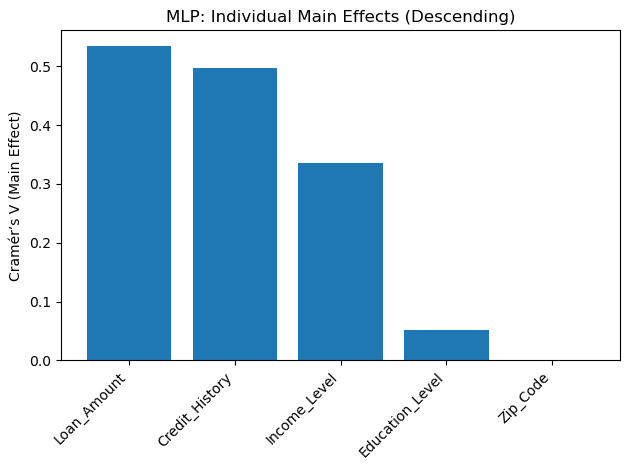

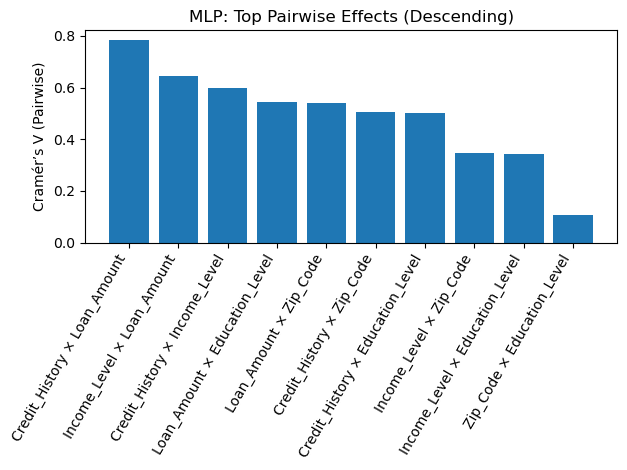

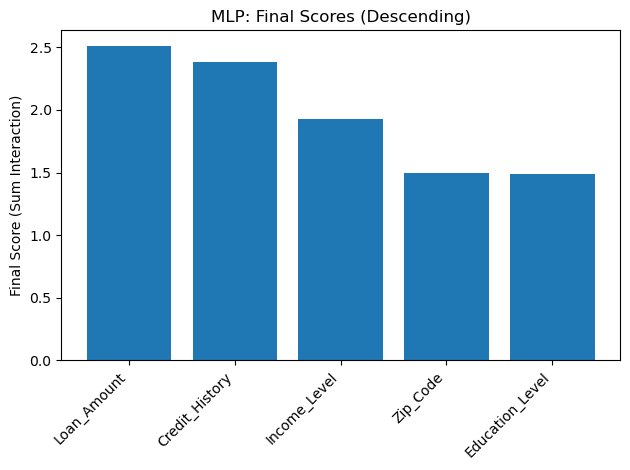

,Feature,Main p-value,Main Effect (V)
0,Loan_Amount,0.000000,0.534380
1,Credit_History,0.000000,0.497674
2,Income_Level,0.000000,0.336258
3,Education_Level,0.017297,0.052008
4,Zip_Code,0.099777,0.000000


,Feature Pair,Interaction p-value,Effect Size (V),Significant?
0,Credit_History × Income_Level,0.0,0.596979,Yes
1,Credit_History × Loan_Amount,0.0,0.782059,Yes
2,Credit_History × Zip_Code,0.0,0.505591,Yes
3,Credit_History × Education_Level,0.0,0.500840,Yes
4,Income_Level × Loan_Amount,0.0,0.645677,Yes


,Feature,Main Effect (V),Sum Interaction (V),Final Score (here: Sum Interaction)
2,Loan_Amount,0.534380,2.510231,2.510231
0,Credit_History,0.497674,2.385469,2.385469
1,Income_Level,0.336258,1.931642,1.931642
3,Zip_Code,0.000000,1.497006,1.497006
4,Education_Level,0.052008,1.490708,1.490708


In [15]:

main_df, pairwise_df, final_df = stat_xai_tables_and_plots(merged_df, MODEL_SUFFIX)
display(main_df.head())
display(pairwise_df.head())
display(final_df.head())


## (Optional) Feature-Recovery Demo

In [ ]:

# If you have known ground-truth causal features (for synthetic data), evaluate recovery:
GT = {"Loan_Amount", "Credit_History", "Income_Level"}  # adjust to your ground truth if known
ranking = (main_df
           .merge(final_df[["Feature", "Sum Interaction (V)"]], on="Feature", how="left")
           .sort_values(["Main Effect (V)", "Sum Interaction (V)"], ascending=False)
           ["Feature"].tolist())
rec_df = compute_feature_recovery_metrics(GT, ranking)
rec_df.insert(0, "Method", f"{MODEL_SUFFIX} + χ² + V")
display(rec_df)
rec_df.to_csv(os.path.join(TABLES_DIR, f"feature_recovery_metrics_{MODEL_SUFFIX}.csv"), index=False)
